In [1]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

from Optical_forward import Optical_forward

# Hyperparameters

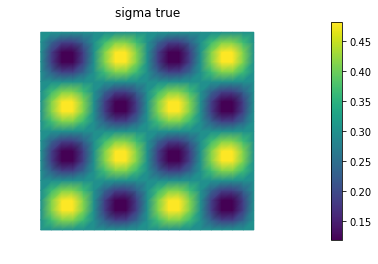

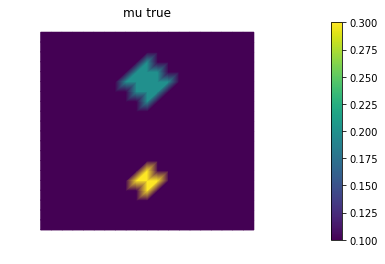

array([ 0.40019874,  0.39980722,  0.39979531,  0.39892308,  0.31331667,
        0.39897072,  0.39797432,  0.26136679,  0.26290998,  0.39818699,
        0.3979476 ,  0.25191793,  0.18366296,  0.25555983,  0.39828535,
        0.39899832,  0.28158533,  0.17089584,  0.17295786,  0.28806811,
        0.39923315,  0.40082128,  0.33430414,  0.21480626,  0.1567748 ,
        0.2202677 ,  0.34392627,  0.40076813,  0.40244934,  0.38804681,
        0.28873459,  0.1935864 ,  0.1964535 ,  0.29886619,  0.39963739,
        0.40215219,  0.40292398,  0.42236949,  0.36130244,  0.25661932,
        0.20614637,  0.26325335,  0.37476762,  0.43328175,  0.40262863,
        0.40200768,  0.42418233,  0.40670258,  0.31764268,  0.23317056,
        0.23573135,  0.32644799,  0.41900435,  0.43189211,  0.40186388,
        0.4002744 ,  0.39177489,  0.40903964,  0.35523435,  0.26164236,
        0.2159124 ,  0.26473412,  0.36168596,  0.41587585,  0.39554022,
        0.40027   ,  0.39858778,  0.33643617,  0.36535905,  0.35

In [2]:
nx = ny = 20
mesh = dl.UnitSquareMesh(nx, ny)
V = dl.FunctionSpace(mesh, 'Lagrange', 1)

sigma_true = dl.interpolate(dl.Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=5),V)
mu_true = dl.interpolate(dl.Expression('0.1 + 0.1*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.75,2),0.5) < 0.1) + 0.2*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.25,2),0.5) < 0.07)', degree=5),V)
gamma = dl.interpolate(dl.Expression('0.03 + 0.01 * sin(2 * pi * x[1])', degree=3), V)
Gamma = dl.Constant("1.0")
fwdSolver = Optical_forward(V, gamma, Gamma)
H = dl.Function(V)
nb.plot(sigma_true)
plt.title("sigma true")
plt.show()

nb.plot(mu_true)
plt.title("mu true")
plt.show()

H.vector().set_local(fwdSolver.Evaluate([sigma_true.vector().get_local(), mu_true.vector().get_local()])[0])

# Prior

In [3]:
xDim=2;
yDim=1;

var = 20    # Marginal Variance
length = 1 # Lengthscale of the kernel
nu = 1.0/2.0 # Smoothness parameter

mean_sigma = ma.LinearMean(np.zeros((1,xDim)), [0.3])
kern_sigma = ma.MaternKernel(xDim, var, length, nu)

#mean_mu = ma.LinearMean(np.zeros((1,xDim)), [0.1])
#kern_mu = ma.MaternKernel(xDim, var, length, nu)

prior_sigma = ma.GaussianProcess(mean_sigma, kern_sigma).Discretize(mesh.coordinates().T).AsDensity()
#prior_mu = ma.GaussianProcess(mean_mu, kern_mu).Discretize(mesh.coordinates().T).AsDensity()

# Likelihood

In [4]:
noiseVar = 10
noiseCov = noiseVar*np.ones((V.dim()))
likelihood = mm.Gaussian(H.vector().get_local(), noiseCov).AsDensity()

# Posterior

In [5]:
#posteriorPiece = mm.DensityProduct(3)
posteriorPiece = mm.DensityProduct(2)
sigma = mm.IdentityOperator(V.dim())
mu = mm.IdentityOperator(V.dim())

# Work Graph

In [6]:
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(sigma, "sigma")
graph.AddNode(mu, "mu")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("sigma", 0, "u", 0)
graph.AddEdge("mu", 0, "u", 1)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(prior_sigma, "Prior Sigma")
graph.AddNode(prior_mu, "Prior Mu")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("sigma", 0, "Prior Sigma", 0)
graph.AddEdge("mu", 0, "Prior Mu", 0)
graph.AddEdge("Prior Sigma",0,"Posterior",0)
graph.AddEdge("Prior Mu",0,"Posterior",1)
graph.AddEdge("Likelihood",0, "Posterior",2)

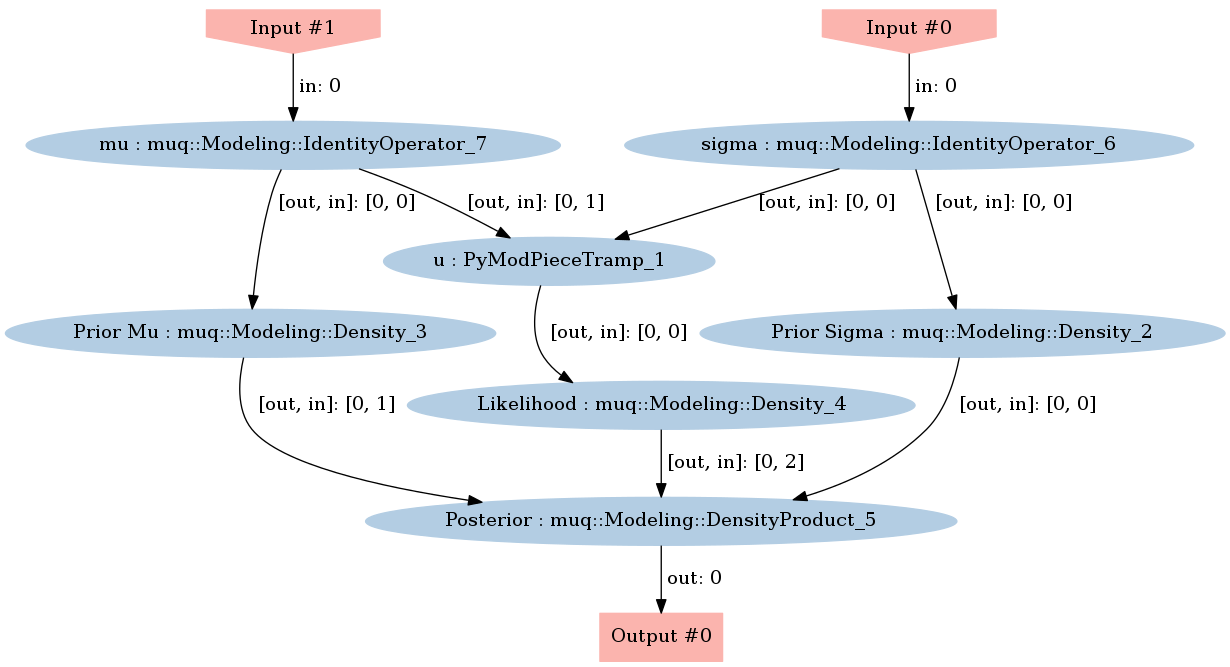

In [7]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [8]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [9]:
proposalOptions = dict()
proposalOptions['Method'] = 'MHProposal'
proposalOptions['ProposalVariance'] = 1e-2

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 5000
options['ThinIncrement'] = 1
options['BurnIn'] = 10
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [14]:
start_sigma = sigma_true.vector().get_local() #0.3*np.ones(V.dim())
start_mu = mu_true.vector().get_local() #0.1*np.ones(V.dim())
samps = mcmc.Run([start_sigma, start_mu])

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 20%
  20% Complete
    Block 0:
      Acceptance Rate = 20%
  30% Complete
    Block 0:
      Acceptance Rate = 20%
  40% Complete
    Block 0:
      Acceptance Rate = 20%
  50% Complete
    Block 0:
      Acceptance Rate = 20%
  60% Complete
    Block 0:
      Acceptance Rate = 20%
  70% Complete
    Block 0:
      Acceptance Rate = 20%
  80% Complete
    Block 0:
      Acceptance Rate = 20%
  90% Complete
    Block 0:
      Acceptance Rate = 20%
  100% Complete
    Block 0:
      Acceptance Rate = 21%
Completed in 98.2075 seconds.


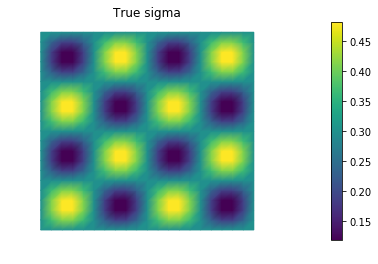

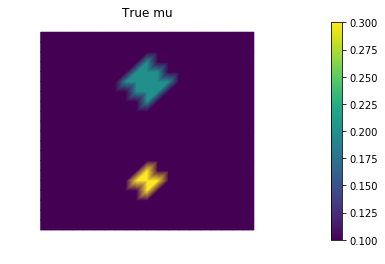

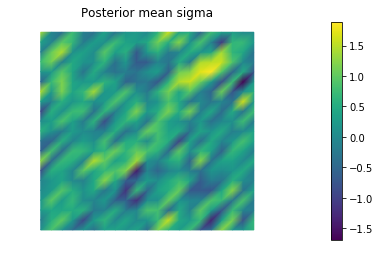

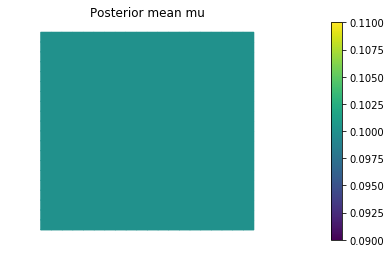

In [11]:
sampMean = samps.Mean()
sampCov = samps.Covariance()
ess = samps.ESS()
mcErr = np.sqrt( samps.Variance() / ess)

nb.plot(sigma_true)
plt.title("True sigma")
plt.show()
nb.plot(mu_true)
plt.title("True mu")
plt.show()

sigma_post = dl.Function(V)
sigma_post.vector().set_local(sampMean[:V.dim()])
nb.plot(sigma_post)
plt.title("Posterior mean sigma")
plt.show()

mu_post = dl.Function(V)
mu_post.vector().set_local(sampMean[V.dim():])
nb.plot(mu_post)
plt.title("Posterior mean mu")
plt.show()

In [12]:
sampMat = samps.AsMatrix()

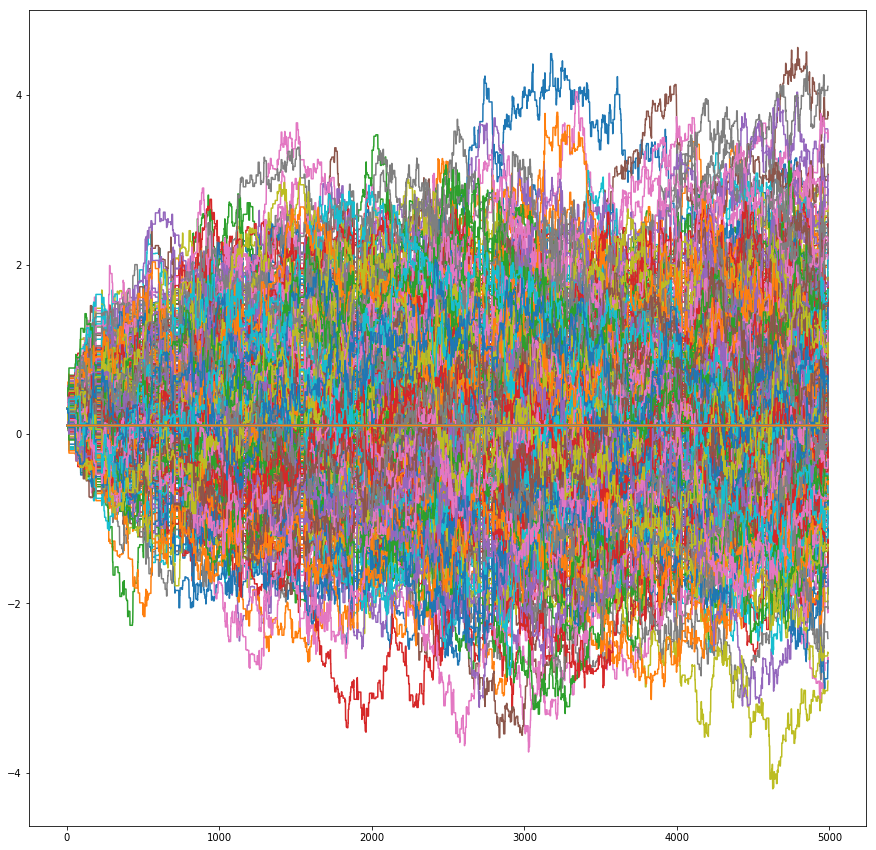

In [13]:
plt.figure(figsize=(15,15))
plt.plot(sampMat.T[:,:])
plt.show()